In [1]:
import os
# Verificación y ubicación (y descarga de archivos en colab)
directory_path = os.getcwd()
folder_name = os.path.basename(directory_path)
if folder_name != 'analysis':
    try:
        os.chdir("/content/CoNet/Tp Final/analysis")
    except FileNotFoundError:
        !git clone https://github.com/facundojgarcia02/CoNet.git
        os.chdir("/content/CoNet/Tp Final/analysis")

In [2]:
from propagation.utils import ReachFinder
import numpy as np
import pandas as pd
import datetime
import pickle
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

try:
    with open("release_data.df", "rb") as pickle_file:
        data_df = pickle.load(pickle_file)
        print("loaded from release_data.df")
except FileNotFoundError:
    # Loading Network
    G = nx.read_gexf("../state_files/PyPi Network V4.gexf")
    # Loading release date data
    with open("../state_files/Filtered Releases.pickle", "rb") as f:
        releases_dict = pickle.load(f)
    known_dates_dict = {lib: {ver: date for ver, date in version_dict.items()
                            if date is not None}
                        for lib, version_dict in releases_dict.items()}
    data_dict = dict()
    now = datetime.datetime.now()
    data_dict["first date"] = {lib: (now - min(version_dict.values())).days for lib, version_dict in known_dates_dict.items()
                            if version_dict}  # False sii version_dict está vacío.
    data_dict["last date"] = {lib: (now - max(version_dict.values())).days for lib, version_dict in known_dates_dict.items()
                            if version_dict}  # False sii version_dict está vacío.
    data_dict["updates"] = {lib: len(version_dict.values()) for lib, version_dict in releases_dict.items()}

    finder = ReachFinder(G)
    reached_libs = finder.find_all_nodes()
    reach = {lib: len(reached_from_lib) for lib, reached_from_lib in reached_libs.items()}
    data_dict["reach"] = reach
    del(G)
    del(reached_libs)
    data_df = pd.DataFrame.from_dict(data=data_dict)
    with open("release_data.df", "wb") as pickle_file:
        pickle.dump(data_df, pickle_file)

loaded from release_data.df


In [3]:
data_df["top reach"] = data_df["reach"] > 1.2e5
data_df["last date"] /= 365
data_df["first date"] /= 365

data_df

,first date,last date,updates,reach,top reach
0-core-client,5.438356,5.098630,5.0,1.0,False
0-orchestrator,5.438356,5.098630,7.0,1.0,False
01d61084-d29e-11e9-96d1-7c5cf84ffe8e,3.189041,3.189041,1.0,3.0,False
0x-contract-addresses,3.852055,2.953425,9.0,9.0,False
0x-contract-artifacts,3.852055,2.953425,5.0,8.0,False
...,...,...,...,...,...
iron-man,NaN,NaN,NaN,2.0,False
tripleo-heat-templates,NaN,NaN,NaN,2.0,False
vidify-audiosync,NaN,NaN,NaN,2.0,False
python-flirt,NaN,NaN,NaN,4.0,False


In [4]:
top_reach_df = data_df[data_df["reach"] > 1.2e5].copy()
top_reach_df["log10 reach"] = np.log10(top_reach_df["reach"])

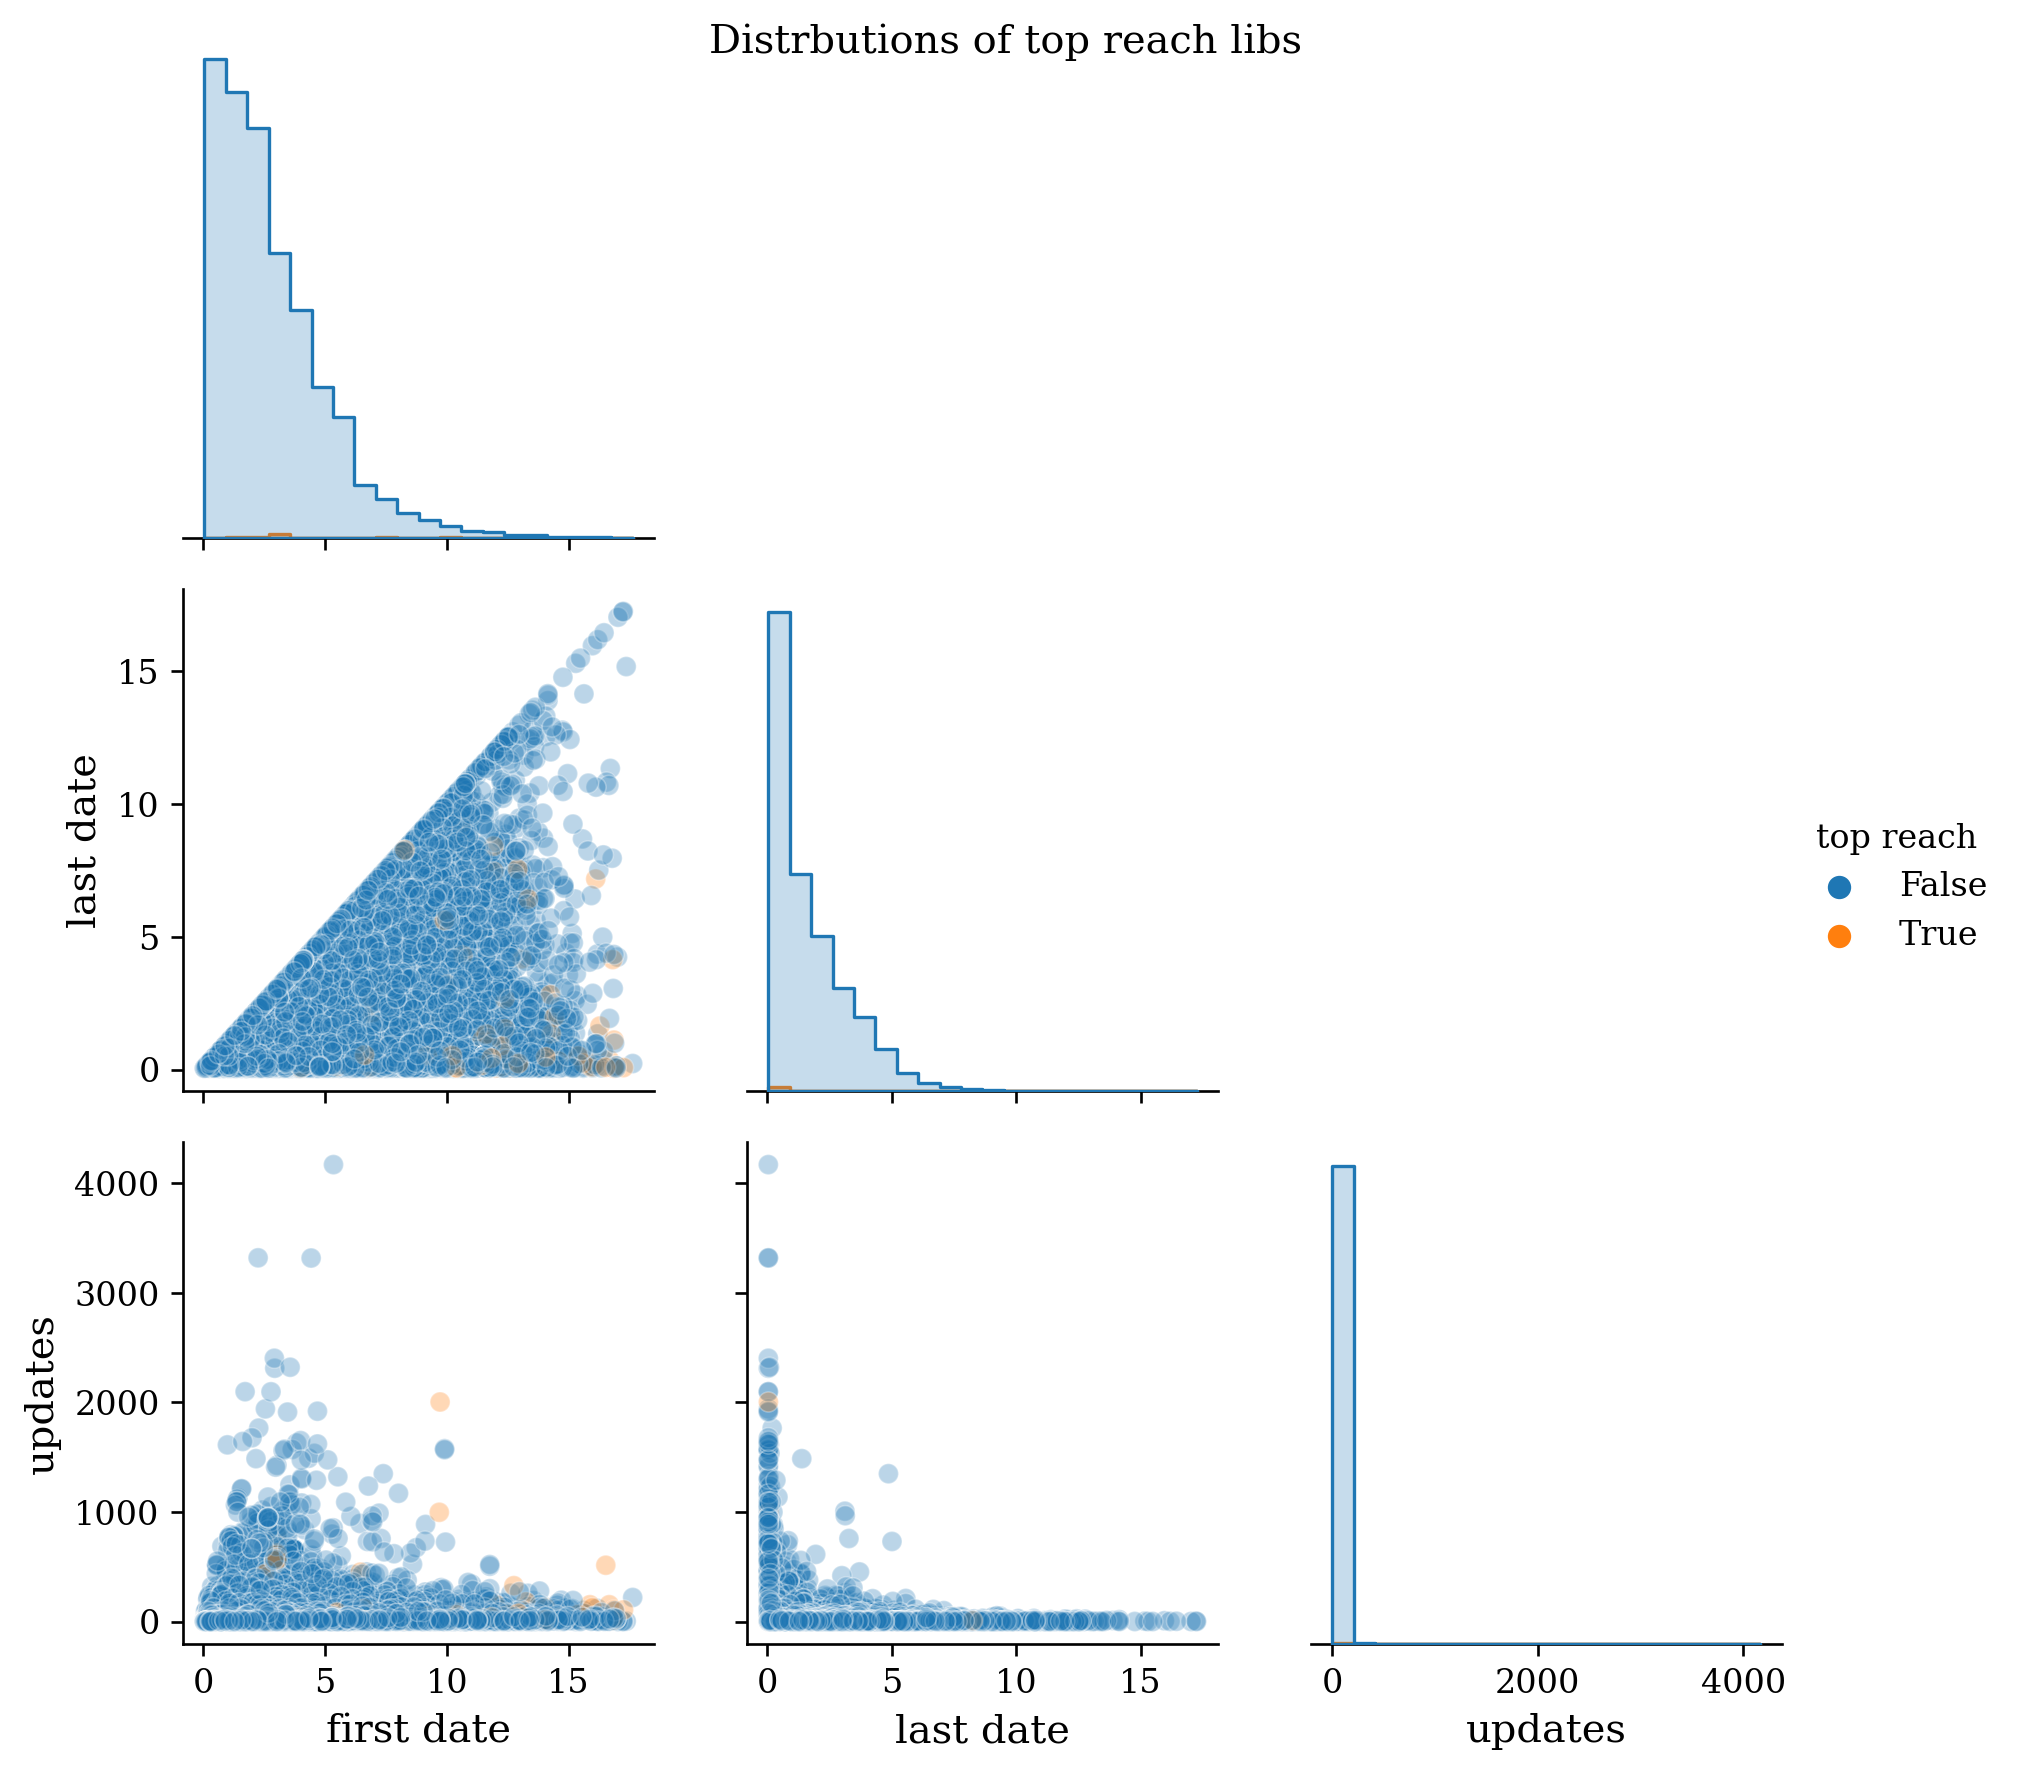

In [12]:
def sns_loghist(data, bins=20, **kwargs):
    return sns.histplot(data, bins=np.geomspace(np.min(data[kwargs["x"]])/2,
                                                2*np.max(data[kwargs["x"]]),
                                                bins),
                        **kwargs)

pg = sns.PairGrid(data=data_df, diag_sharey=False, corner=True,
                  vars=["first date", "last date", "updates"],
                  hue="top reach", hue_order=[False, True])
# pg.map_diag(sns_loghist, element="step", multiple="layer", bins=10,)
pg.map_diag(sns.histplot, element="step", bins=20)
pg.map_lower(sns.scatterplot, alpha=0.3)
# pg.set(yscale="log", xscale="log")
pg.figure.suptitle("Distrbutions of top reach libs")
pg.add_legend()
plt.show()

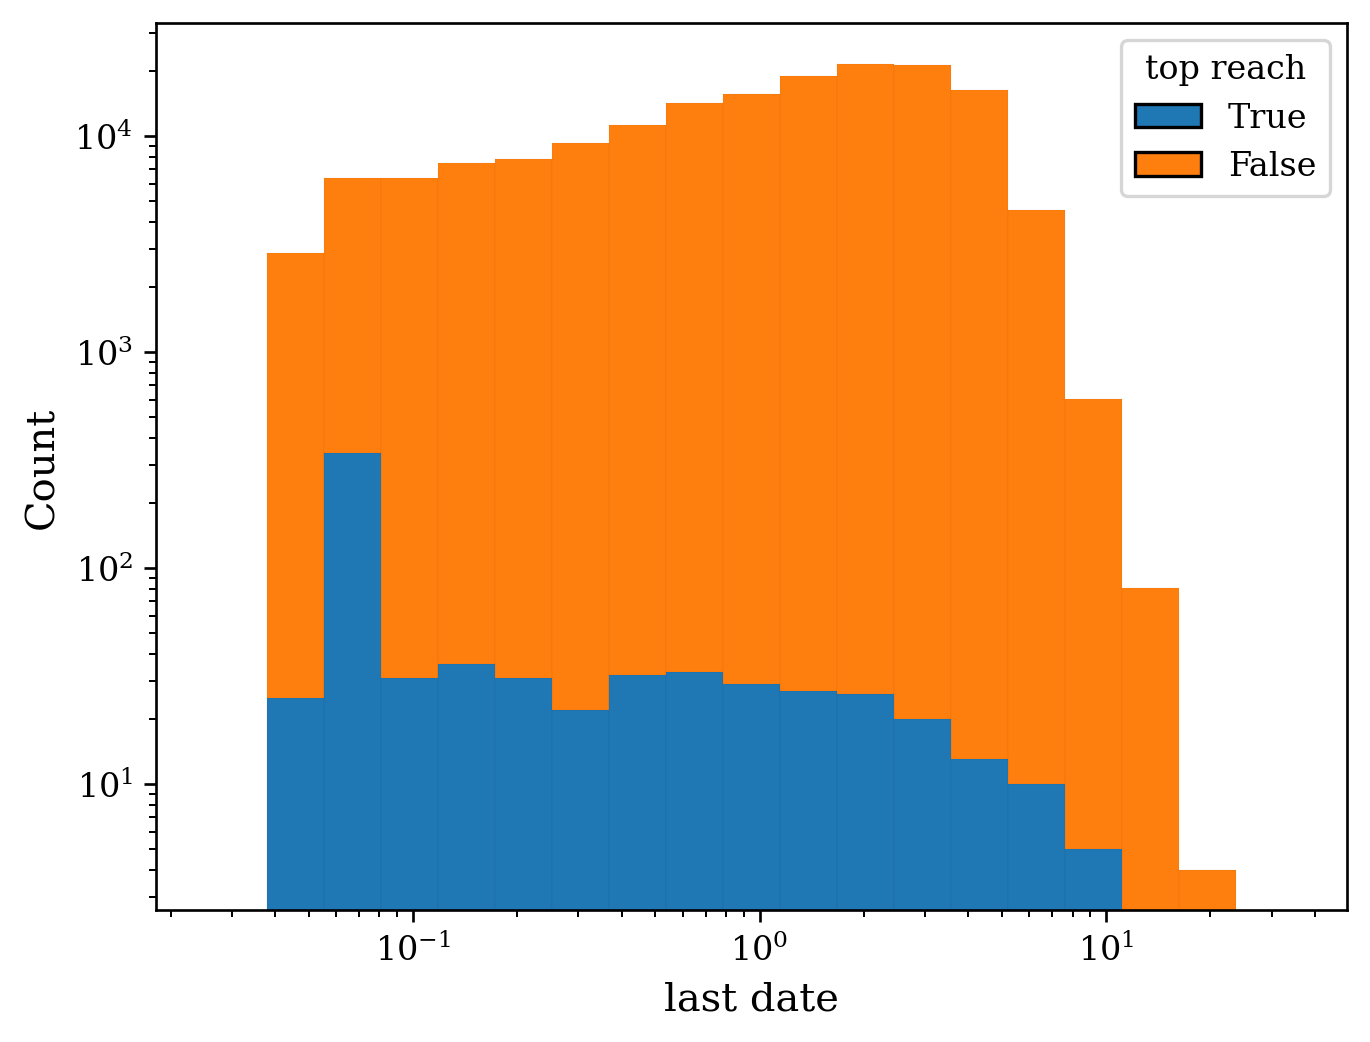

In [13]:
sns_loghist(data_df, x="last date", hue="top reach",
             multiple="layer", hue_order=[True, False], alpha=1,)
plt.yscale("log")
plt.xscale("log")

plt.show()

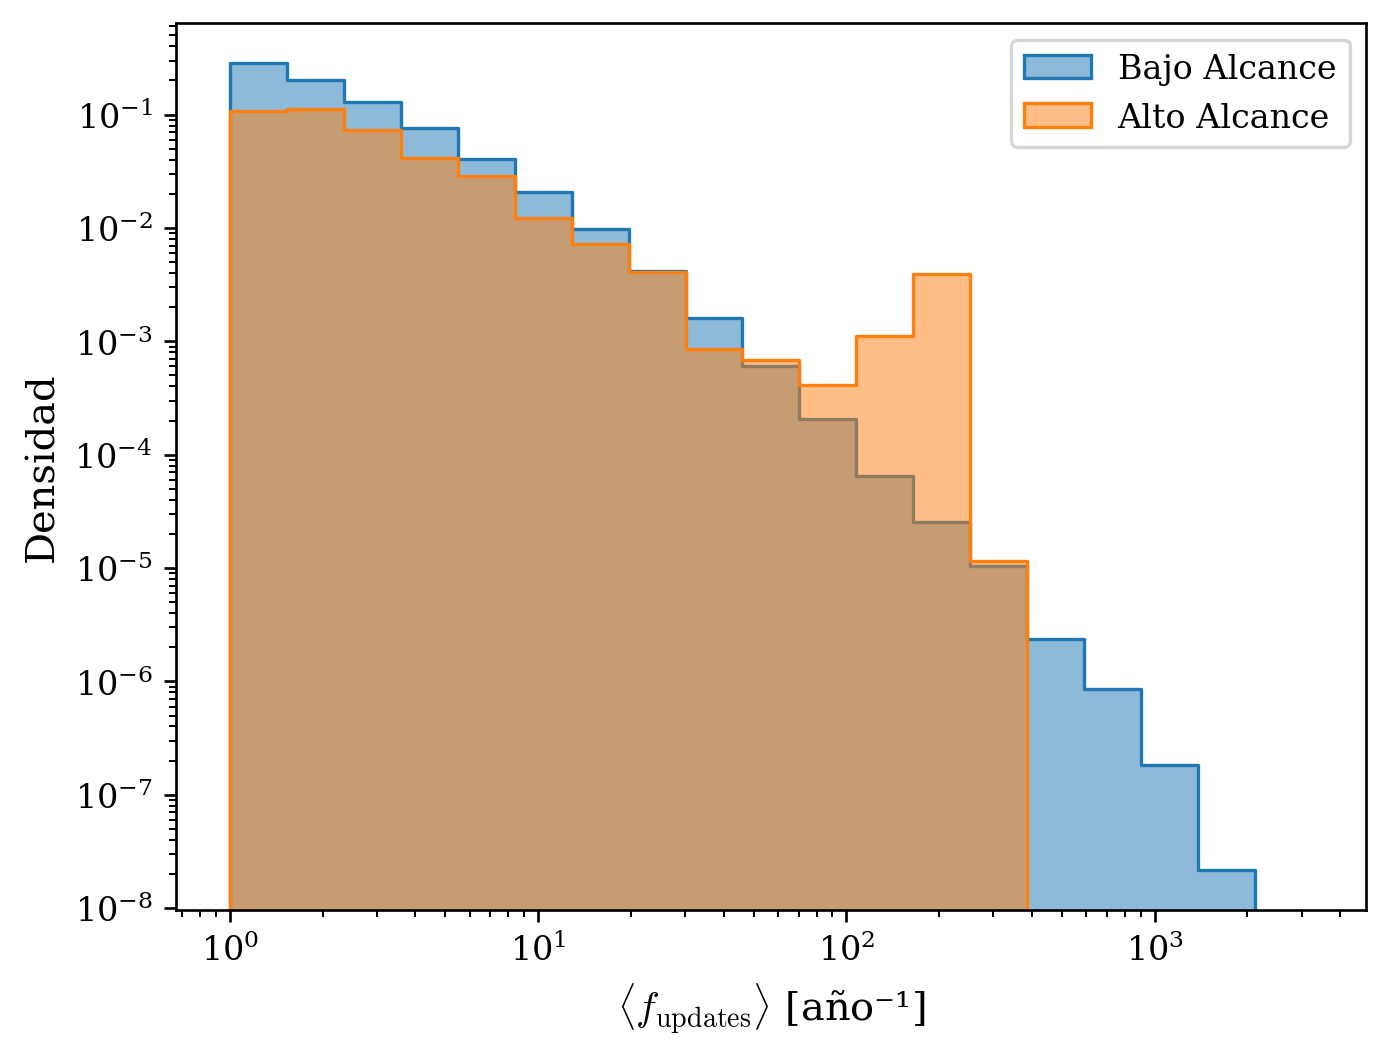

In [56]:
var_vals = data_df["updates"]/data_df["first date"]
# _, bin_edges = np.histogram(var_vals.fillna(0), )
bin_edges = np.geomspace(1, 2*var_vals.max(), 20)
sns.histplot(var_vals[~data_df["top reach"]], bins=bin_edges,
             element="step", alpha=0.5, stat="density", label="Bajo Alcance")
sns.histplot(var_vals[data_df["top reach"]], bins=bin_edges,
             element="step", alpha=0.5, stat="density", label="Alto Alcance")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel(r"$\langle f_\mathrm{updates} \rangle$ [año⁻¹]")
plt.ylabel("Densidad")
plt.show()

In [76]:
top_reach_df.sort_values("reach", ascending=False).head(50)

,first date,last date,updates,reach,log10 reach,first date [years ago],last date [years ago]
numpy,5828.0,34.0,126.0,138769.0,5.142292,15.0,0.0
typing-extensions,1885.0,40.0,19.0,136502.0,5.135139,5.0,0.0
six,4522.0,559.0,28.0,135902.0,5.133226,12.0,1.0
pyyaml,NaN,NaN,NaN,135573.0,5.132173,NaN,NaN
pytz,6297.0,28.0,107.0,135040.0,5.130462,17.0,0.0
markupsafe,NaN,NaN,NaN,134818.0,5.129748,NaN,NaN
babel,NaN,NaN,NaN,134781.0,5.129629,NaN,NaN
jinja2,NaN,NaN,NaN,134750.0,5.129529,NaN,NaN
python-dateutil,5214.0,489.0,32.0,134593.0,5.129022,14.0,1.0
colorama,4593.0,21.0,46.0,134428.0,5.128490,12.0,0.0
